In [141]:
import pandas as pd, numpy as np

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%a\n%m/%d')

import seaborn as sns

In [189]:
pd.options.display.max_rows = 999

In [142]:
from sklearn.linear_model import LinearRegression

In [143]:
# Import COVID data from the NY Times
path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
covid = pd.read_csv(path)
covid['date'] = pd.to_datetime(covid.date)

# Import census population data by county for 2018
path = 'http://www.wtad.com/assets/news_files/PEP_2018_PEPANNCHG.ST05_with_ann.xlsx'
pop = pd.read_excel(path)
pop = pop.rename(columns={'GC.target-geo-id2':'fips',
                'respop72018':'population'})
pop = pop[['fips','population']]
pop = pop.loc[1:]
pop['population'] = pd.to_numeric(pop['population'])
pop['fips'] = pd.to_numeric(pop.fips)

In [144]:
# Import MSA mapping 
# Clean up MSA names to keep the major city and state
path = "https://raw.githubusercontent.com/dri3s/covidviz/master/metrolist.csv"
msa = pd.read_csv(path, nrows=1160, header=None, names=['msa_fips','msa_name','fips','county_name'])

msa.fips = pd.to_numeric(msa['fips'])
msa = msa.drop(columns=['msa_fips','county_name'])

msasplit = msa.msa_name.str.split(pat=',|-', expand=True)
msasplit['state'] = None

for idx, row in msasplit.iterrows():
    for col in row:
        try:
            state = col.strip()[0:2]
            if state.isupper() and msasplit.loc[idx, 'state'] == None:
                msasplit.loc[idx, 'state'] = state
                continue
        except:
            continue

msasplit = msasplit.rename(columns={0:'city'})

msasplit = msasplit[['city','state']]
msa[['city','state']] = msasplit
msa['msa_name'] = msa.city + ', ' + msa.state

In [145]:
# Make sure there are records for every single day - fill null values with zeroes
calshell = pd.DataFrame(covid.date.unique(), columns=['date'])
calshell['key'] = 1
pop['key'] = 1
covidmsa = calshell.merge(pop).merge(msa).merge(covid, how='left', on=['fips','date'])
covidmsa = covidmsa.fillna(0)

In [146]:
# Combine covid, population, and MSA data
# Sum by MSA and compute cases per capita
covidmsa = covidmsa.drop(columns=['fips','key']).groupby(['date','msa_name']).sum().reset_index()
covidmsa['caseperk'] = (covidmsa.cases/covidmsa['population']) * 1000
covidmsa = covidmsa.sort_values(by=['msa_name','date']).reset_index(drop=True)
covidmsa = covidmsa.loc[covidmsa.cases >= 10]
covidmsa ['num_days'] = (covidmsa.date - covidmsa.groupby(['msa_name'])['date'].transform('min')).dt.days

In [147]:
covidmsa.loc[covidmsa.date == covidmsa.date.max()].sort_values('caseperk')

,date,msa_name,population,cases,deaths,caseperk,num_days
5809,2020-04-12,"Chico, CA",231256,14.0,0.0,0.060539,10
12366,2020-04-12,"Hanford, CA",151366,10.0,1.0,0.066065,1
30377,2020-04-12,"Wausau, WI",163117,13.0,1.0,0.079697,8
31622,2020-04-12,"Yuma, AZ",212128,17.0,0.0,0.080140,13
746,2020-04-12,"Altoona, PA",122492,10.0,0.0,0.081638,1
...,...,...,...,...,...,...,...
3900,2020-04-12,"Bridgeport, CT",943823,5534.0,248.0,5.863388,29
20583,2020-04-12,"New York, NY",19303808,127205.0,4504.0,6.589632,39
22990,2020-04-12,"Poughkeepsie, NY",675669,6865.0,142.0,10.160300,29
20500,2020-04-12,"New Orleans, LA",1270399,13105.0,540.0,10.315657,32


In [179]:
def GetDouble(df):
    df['lncase'] = np.log(df.cases)
    df = df.sort_values(by='date')

    X = df.tail(5).num_days.values.reshape(-1, 1)
    y = df.tail(5).lncase.values

    reg = LinearRegression().fit(X, y)

    return round(np.log(2)/reg.coef_[0], 1)

doubling = covidmsa.groupby('msa_name').apply(lambda x: GetDouble(x)).reset_index()
doubling = doubling.rename(columns={0: 'doubling'})
doubling = doubling.loc[doubling.doubling != np.inf]
doubling = doubling.sort_values(by='doubling').reset_index(drop=True)

In [196]:
worst = doubling.head(10).msa_name.tolist()

In [ ]:
# Mark the 10 worst MSAs and include others of interest
#worst = list(covidmsa.groupby('msa_name').
#             caseperk.max().reset_index().
#             sort_values('caseperk').tail(10).msa_name.values)

In [197]:
dets = list(covidmsa.loc[covidmsa.msa_name.str.contains('Dallas')].msa_name.unique())
dets.append(covidmsa.loc[covidmsa.msa_name.str.contains('Houston')].msa_name.unique()[0])

# These are cities with quarantine facilities that had lots of patients early on 
# They are outliers and should be excluded
exclude = ['San Antonio, TX','Omaha, NE','Vallejo, CA']

Text(0.9, 0.01, 'Data current through 04/12')

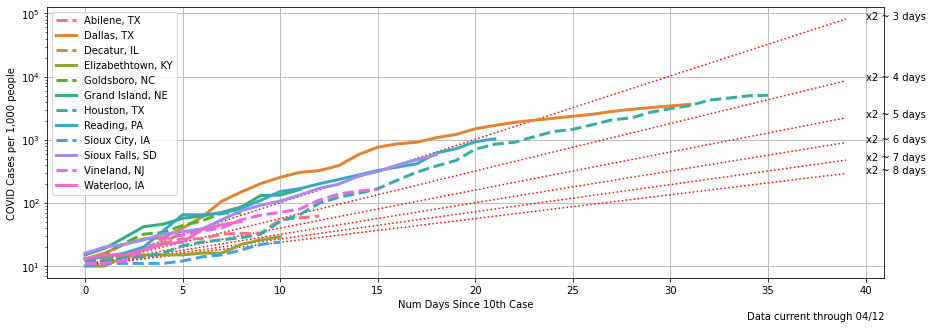

In [200]:
exp = pd.DataFrame(np.arange(40), columns=['num_days'])
ds = list(range(3, 9))
for d in ds:
    exp['double{}'.format(d)] = 10 * np.exp(exp.num_days * (np.log(2)/d))

colors = iter(sns.color_palette('husl', len(worst) + len(dets)))

plt.rcParams['figure.figsize'] = 15, 5
fig, ax = plt.subplots()

for d in ds:
    ys = exp['double{}'.format(d)]
    ax.plot(exp.num_days, ys, ls='dotted', color='red')
    plt.text(exp.num_days.max() + 1, ys.max(), 'x2 ~ {} days'.format(d))


i = 0

for msaname, df in covidmsa.groupby('msa_name'):    
    if msaname in exclude:
        continue
    
    df = df.sort_values(by='caseperk')
    
    if msaname in worst or msaname in dets:
        label = msaname
        color = next(colors)
        lw, alpha = (3, 1)
        
        if i%2 == 0: ls = '--'
        else: ls = '-'
            
        i += 1
    else:   
        continue
        label = '_nolabel_'
        color='gray'
        lw, alpha = (0.4, 0.4)
        ls = '-'
        
    if msaname in dets:        
        #lw = 5    
        pass
    
    #ax.plot(covidmsa.loc[covidmsa.fips == fips]['date'],
    ax.plot(df['num_days'],
            df['cases'], 
            label=label,
            color=color,
            lw=lw,
            alpha=alpha,
            ls = ls
            )    
    
    
#ax.set_xlim([pd.to_datetime('15feb2020'),pd.to_datetime(date.today())])
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(mdates.MO))

#ax.set_xlim([0, covidmsa.num_days.max()])

ax.set_yscale('log', basey=10)

ax.set_ylabel('COVID Cases per 1,000 people')
ax.set_xlabel('Num Days Since 10th Case')
ax.legend()
ax.grid()

plt.figtext(0.9, 0.01, 'Data current through {:%m/%d}'.format(covidmsa.date.max()), horizontalalignment='right') 